<a href="https://colab.research.google.com/github/Madhan-sukumar/NLP/blob/main/Quora%20Insincere%20Questions%20Classification/Insincere_Questions_Classification_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks and Embeddings for Natural Language Processing

### Problem Statement: 

An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.To Identify and Flag Insincere Questions asked in Quora using Deep Neural Network Classification Model


Dataset: https://www.kaggle.com/c/quora-insincere-questions-classification


### File descriptions
- train.csv - the training set
- test.csv - the test set


### Data fields

1. qid - unique question identifier
2. question_text - Quora question text
3. target - a question labeled "insincere" has a value of 1, otherwise 0

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

In [1]:
import os

In [2]:
!pwd

/content


In [3]:
#setting the current diretory for the kaggle to use credentials and to download data
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
#downloading the data from kaggle
!kaggle competitions download -c quora-insincere-questions-classification -f train.csv
!kaggle competitions download -c quora-insincere-questions-classification -f test.csv 

 89% 49.0M/54.9M [00:00<00:00, 65.3MB/s]
100% 54.9M/54.9M [00:00<00:00, 68.3MB/s]
 63% 10.0M/15.8M [00:00<00:00, 35.9MB/s]
100% 15.8M/15.8M [00:00<00:00, 53.1MB/s]


In [5]:
#storing the files
train_fname = '/content/train.csv.zip'
test_fname = '/content/test.csv.zip'

## Data Loading

In [70]:
import numpy as np
import pandas as pd

In [7]:
raw_df = pd.read_csv(train_fname)
test_df = pd.read_csv(test_fname)

In [8]:
raw_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
test_df.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [11]:
#shape of raw dataframe
raw_df.shape

(1306122, 3)

In [12]:
#shape of test dataframe
test_df.shape

(375806, 2)

Having a 300K number of rows, So we taking 100000 rows as a sample data

In [13]:
sample_size = 100_000
sample_df = raw_df.sample(sample_size)

In [14]:
sample_df.shape

(100000, 3)

In [15]:
sample_df.target.value_counts(normalize = True)

0    0.93758
1    0.06242
Name: target, dtype: float64

From the sampled target attribute, can see that the data is imbalanced with the classes 

## Prepare Data for Training

#### Outline:

1. Convert text to TF-IDF Vectors
2. Split training & validation set
3. Convert to PyTorch tensors

### Convert Text to TF-IDF Vectors

In [16]:
import nltk
nltk.download('punkt')

#tokenization
from nltk.tokenize import word_tokenize

#stemming
from nltk.stem.snowball import SnowballStemmer

#stopwords
from nltk.corpus import stopwords 
nltk.download('stopwords')

#vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
#iniitiating stemmer
stemmer = SnowballStemmer("english")

In [18]:
#creating a function for stemming and tokenization
def tokenize(text):
  return [stemmer.stem(word) for word in word_tokenize(text)]

In [19]:
#stopwords
stop_words = stopwords.words('english')
print(stop_words)
print(len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [20]:
Vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words = stop_words, max_features = 1000 )

In [21]:
sample_df

,qid,question_text,target
814528,9f99c5dbfef56cea445d,Why do many seem to feel Barack Obama was a go...,0
429604,5430f9560980e2b65464,"What are fun things to do in Werfen, Austria?",0
279003,369c2a0f5459d74f2bcc,How do y’all think Michael Jackson would’ve re...,0
189256,2502901ffdccc2ab378b,How is the best way to get HR jobs?,0
856140,a7bcc0fac297092e3bb0,How can I manage time with lot of works?,0
...,...,...,...
783039,99656974d3d2e7552d02,Does lightning strike you when using a mobile ...,0
344120,436b4352d5e3f584ceee,Does a single atom in a perfect vacuum have a ...,0
59405,0ba611427e3e281897d6,What is the best job for women in Hyderabad?,0
733873,8fbc5d181cae6681abdd,What seemingly insignificant thing would you m...,0


In [22]:
#fitting the vectorizer to learn the vocabulary
Vectorizer.fit(sample_df.question_text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7f750f0b36d0>)

In [23]:
" ".join(Vectorizer.get_feature_names_out())

"! $ % & ' '' 'm 's ( ) , - . 1 10 100 12 12th 15 2 20 2017 2018 3 4 5 50 6 7 8 : ? [ ] `` abl abroad abus accept access accomplish accord account achiev acid act action activ actor actual ad add address admiss adult advanc advantag advic affect africa african age ago air allow alon alreadi also alway amazon america american among amount android ani anim anoth answer anyon anyth apart app appear appl appli applic approach arab area armi around art articl asian ask atheist attack attract australia author avail averag avoid away babi back bad ball ban bangalor bank base basic batteri beauti becaus becom befor behind believ benefit best better big biggest bill biolog bit bitcoin black block blog blood board bodi book born boy boyfriend brain branch brand break bring british brother build busi buy c ca calcul call canada candid car card care career carri case cast cat caus cbse celebr cell center certain certif challeng chanc chang channel charact characterist charg check chemic chemistri 

## Transforming the Raw and Test DataFrame

In [24]:
#transforming the Raw Dataframe
inputs = Vectorizer.transform(sample_df.question_text)

In [25]:
inputs.shape

(100000, 1000)

In [26]:
test_df.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [27]:
#transforming the Test Dataframe
test_inputs = Vectorizer.transform(test_df.question_text)

## Preparing Data for Training

In [28]:
# splitting the df for training and validation
from sklearn.model_selection import train_test_split

In [29]:
targets = sample_df.target

In [30]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs,targets,test_size=0.3)

In [31]:
train_inputs.shape

(70000, 1000)

In [32]:
val_inputs.shape

(30000, 1000)

In [33]:
train_targets.shape

(70000,)

In [34]:
val_targets.shape

(30000,)

## Converting Array to Tensors

In [35]:
import torch

In [36]:
#converting train and validation inputs to tensors
#using toarray since it is sparse matrix after vectorized
train_input_tensors = torch.Tensor(train_inputs.toarray()).float()
val_input_tensors = torch.Tensor(val_inputs.toarray()).float()

In [37]:
train_input_tensors.size()

torch.Size([70000, 1000])

In [38]:
val_input_tensors.size()

torch.Size([30000, 1000])

In [39]:
print(train_targets)
print(type(train_targets))

754840     0
508087     0
1217831    0
1115       0
50367      0
          ..
381727     0
501630     0
273955     0
360854     0
732046     0
Name: target, Length: 70000, dtype: int64
<class 'pandas.core.series.Series'>


In [40]:
#converting traing and validation targets to tensors
#using values since the targets are pandas series
train_target_tensors = torch.tensor(train_targets.values).float()
val_target_tensors = torch.tensor(val_targets.values).float()

In [41]:
# converting test dataframe to tensors
test_input_tensors = torch.tensor(test_inputs.toarray()).float()

## Converting Tensors to Dataloaders

In [42]:
from torch.utils.data import TensorDataset, DataLoader

In [43]:
#merging inputs and target tensors as a dataset
train_ds = TensorDataset(train_input_tensors,train_target_tensors)
val_ds = TensorDataset(val_input_tensors,val_target_tensors)
test_ds = TensorDataset(test_input_tensors)

In [44]:
train_ds[:10]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [45]:
#creating a Dataloader
train_dl = DataLoader(dataset= train_ds, batch_size = 128, shuffle =True)
val_dl = DataLoader(dataset = val_ds, batch_size = 128) # shuffle is not necessary
test_dl = DataLoader(dataset= test_ds,batch_size = 128) #shuffle is not necessary

In [46]:
# for creating a batch
# for batch in train_dl:
#   batch_inputs = batch[0]
#   batch_targets = batch[1]
#   print('batch input shape:',batch_inputs.shape)
#   print('batch target shape:',batch_targets.shape)
#   break

In [47]:
len(train_dl)

547

In [48]:
#there are 547 batches and in each batch there are 128 rows
547*128

70016

## Creating a Deep NN

In [49]:
import torch.nn as nn
import torch.nn.functional as F

class QuoraNet (nn.Module):
  def __init__(self):
    super().__init__()

    #creating a 4 layred dnn from 1000 inputs to 1 output 

    #with 1000 inputs and reduced to 512 outputs then to 256 and finally 1 output
    self.layer1 = nn.Linear( 1000, 512)  
    self.layer2 = nn.Linear(512, 256)
    self.layer3 = nn.Linear(256,128)
    self.layer4 = nn.Linear(128,1) 
  
  def forward(self, inputs):
    out = self.layer1(inputs)
    out = F.relu(out)
    out = self.layer2(out)
    out = F.relu(out)
    out = self.layer3(out)
    out = F.relu(out)
    out = self.layer4(out)
    return out


In [107]:
model = QuoraNet()

In [51]:
from sklearn.metrics import accuracy_score, f1_score

In [52]:
#lets create a loop and pass only for first batch to the model to check how it works

for batch in train_dl:
  batch_input, batch_target = batch
  print('batch input shape:',batch_input.shape)
  print('batch target shape:',batch_target.shape)
  
  batch_output = model(batch_input)   #prediction
  print('batch output shape:', batch_output.shape)

  #convert outputs to probabilities
  probs = torch.sigmoid(batch_output[:,0])

  #converting probabilities to prrediction (0 or 1)
  pred = (probs > 0.5).int()

  #printing accuracy and f1-score
  print('Accuracy:', accuracy_score(batch_target,pred))
  print('F1 Score;', f1_score(batch_target,pred))

  #calculating the loss
  #assigning Binary Cross Entropy Loss function
  loss = F.binary_cross_entropy(pred.float(),batch_target)
  break

batch input shape: torch.Size([128, 1000])
batch target shape: torch.Size([128])
batch output shape: torch.Size([128, 1])
Accuracy: 0.03125
F1 Score; 0.06060606060606061


In [53]:
batch_target[:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [54]:
#prediction before training using random weights
batch_output[:10]

tensor([[0.0552],
        [0.0562],
        [0.0550],
        [0.0551],
        [0.0545],
        [0.0549],
        [0.0560],
        [0.0551],
        [0.0545],
        [0.0553]], grad_fn=<SliceBackward0>)

In [55]:
#converted probabilities of batch_output 
probs[:10]

tensor([0.5138, 0.5140, 0.5137, 0.5138, 0.5136, 0.5137, 0.5140, 0.5138, 0.5136,
        0.5138], grad_fn=<SliceBackward0>)

In [56]:
#transformed probabilites to 0 or 1
pred[:10]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)

## Creating the Evaluation

In [106]:
def evaluate(model, dl):
    losses, acc, f1 = [], [], []

    for batch in dl:
        # Get inputs and targets
        batch_input, batch_target = batch

        # Pass inputs through model
        batch_output = model(batch_input)

        # Convert outputs to probabilities
        probs = torch.sigmoid(batch_output[:, 0])

        # Converting probabilities to predictions (0 or 1)
        pred = (probs > 0.5).int()

        # Calculating accuracy and f1-score
        accs = accuracy_score(batch_target, pred)
        f1s = f1_score(batch_target, pred)

        # Calculating the loss using Binary Cross Entropy Loss function
        loss = F.binary_cross_entropy(probs.float(), batch_target,weight = torch.tensor(20))

        losses.append(loss.item())
        acc.append(accs)
        f1.append(f1s)

    return torch.mean(torch.tensor(losses)).item(), torch.mean(torch.tensor(acc)).item(), torch.mean(torch.tensor(f1)).item()


In [102]:
#passing training dataloader to evaluate the base perfomance
evaluate(model, train_dl)

(0.03301083296537399, 0.9901369482893707, 0.911437936150971)

In [103]:
#passing validation dataloader to evaluate the base perfomance
evaluate(model, val_dl)

(0.21978628635406494, 0.9425199468085106, 0.41687888009048896)

## Training on training dataloader and evaluating Validation dataloader

In [104]:
#Train the model batch by batch
def fit(epochs,lr,model,train_dl,val_dl):
  #tracking the history
  history = []

  #defining optimiser
  optimiser = torch.optim.Adam(model.parameters(), lr,weight_decay=1e-5)

  for epoch in range(epochs):
    
    #looping for all batches in train_dl for training
    for batch in train_dl:
      #get inputs and targets
      batch_input, batch_target = batch

      #pass inpts through model
      batch_output = model(batch_input)

      #convert outputs to probabilities and accessing 1 element
      probs = torch.sigmoid(batch_output[:,0])


      #calculating the loss using Binary Cross Entropy Loss function 
      #weight is to treat imbalanced dataset equally
      loss = F.binary_cross_entropy(probs,batch_target, weight = torch.tensor(20))

      #backward pass
      loss.backward()

      #updating the weigts
      optimiser.step()

      #empty the gradients
      optimiser.zero_grad()

    # evaluating on validataion dataloader
    loss, acc,f1 = evaluate(model, val_dl) 
    print("Epoch {}; Loss {:.4f}; Accuracy {:.4f}; F1 {:.4f}".format(epoch+1,loss,acc,f1))

    history.append([loss,acc,f1])
  return history

In [108]:
history = []

#to view the base performance on val dl before training
history.append(evaluate(model,val_dl))

In [109]:
history

[(14.169585227966309, 0.062012411347517726, 0.11606407894728198)]

In [110]:
#fitting the model for training
history += fit(5,0.001,model,train_dl,val_dl)

Epoch 1; Loss 3.1557; Accuracy 0.9431; F1 0.3301
Epoch 2; Loss 3.0499; Accuracy 0.9436; F1 0.3901
Epoch 3; Loss 3.1124; Accuracy 0.9449; F1 0.4081
Epoch 4; Loss 3.4860; Accuracy 0.9420; F1 0.4399
Epoch 5; Loss 4.3445; Accuracy 0.9395; F1 0.3923


In [111]:
history

[(14.169585227966309, 0.062012411347517726, 0.11606407894728198),
 [3.155738353729248, 0.9430851063829787, 0.3300985915108832],
 [3.049851894378662, 0.9436170212765957, 0.3901024175713418],
 [3.1123504638671875, 0.9449024822695036, 0.40814905193029166],
 [3.485952854156494, 0.9420434397163121, 0.43994057363637756],
 [4.344474792480469, 0.9395279255319149, 0.3922892932327868]]

In [112]:
#fitting the model for training with different epoch and learning rate
history += fit(10,0.0001,model,train_dl,val_dl)

Epoch 1; Loss 5.3573; Accuracy 0.9376; F1 0.4118
Epoch 2; Loss 5.9745; Accuracy 0.9403; F1 0.3827
Epoch 3; Loss 6.2837; Accuracy 0.9393; F1 0.3898
Epoch 4; Loss 6.5348; Accuracy 0.9396; F1 0.3885
Epoch 5; Loss 6.7504; Accuracy 0.9393; F1 0.3870
Epoch 6; Loss 6.8688; Accuracy 0.9390; F1 0.3912
Epoch 7; Loss 6.9733; Accuracy 0.9386; F1 0.3885
Epoch 8; Loss 7.1227; Accuracy 0.9391; F1 0.3880
Epoch 9; Loss 7.2075; Accuracy 0.9387; F1 0.3891
Epoch 10; Loss 7.1335; Accuracy 0.9382; F1 0.3849


In [113]:
history

[(14.169585227966309, 0.062012411347517726, 0.11606407894728198),
 [3.155738353729248, 0.9430851063829787, 0.3300985915108832],
 [3.049851894378662, 0.9436170212765957, 0.3901024175713418],
 [3.1123504638671875, 0.9449024822695036, 0.40814905193029166],
 [3.485952854156494, 0.9420434397163121, 0.43994057363637756],
 [4.344474792480469, 0.9395279255319149, 0.3922892932327868],
 [5.357297420501709, 0.9376440602836879, 0.411831692002532],
 [5.974538803100586, 0.9402593085106383, 0.38272353256177427],
 [6.283735752105713, 0.9393284574468085, 0.3897880288516439],
 [6.534787654876709, 0.939561170212766, 0.3884834536343287],
 [6.750418663024902, 0.9392619680851064, 0.3870072468805295],
 [6.868807315826416, 0.9389627659574468, 0.3912032015654536],
 [6.973319053649902, 0.9385970744680852, 0.3884574872625153],
 [7.1227264404296875, 0.9390625, 0.3879613029105244],
 [7.207514762878418, 0.9387189716312058, 0.3891217072595998],
 [7.133508205413818, 0.9381870567375887, 0.384891718030298]]

In [115]:
losses = [item[0] for item in history]
Accuracy = [item[1] for item in history]
F1 = [item[2] for item in history]

## Plotting

In [116]:

import matplotlib.pyplot as plt


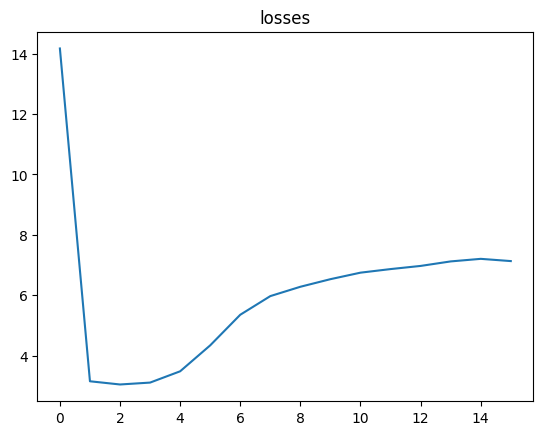

In [117]:
plt.title('losses')
plt.plot(losses)

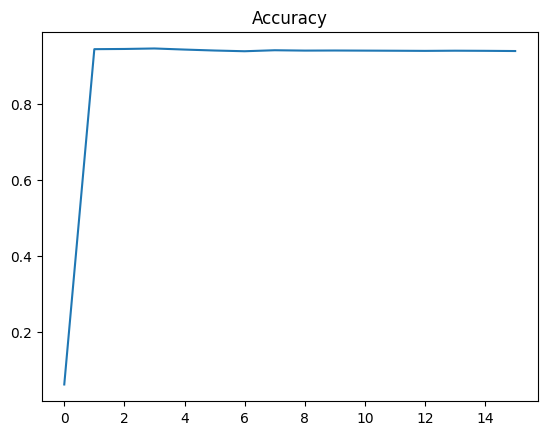

In [118]:
plt.title('Accuracy')
plt.plot(Accuracy)

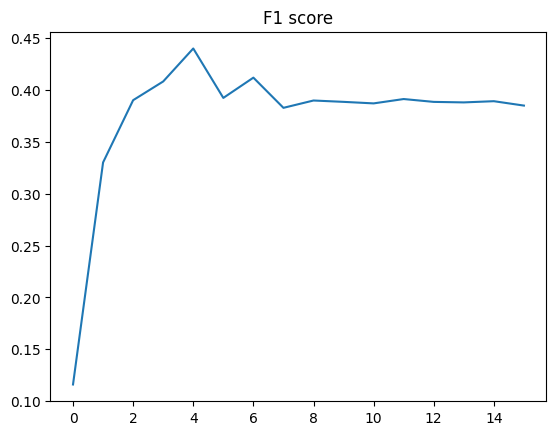

In [119]:
plt.title('F1 score')
plt.plot(F1)

# PREDICTION ON SAMPLE DATA

In [144]:
sample_test = raw_df.sample(10)
sample_test

,qid,question_text,target
239537,2edc9a1318cea0fc7ba7,How is Ukraine today? Has the crisis with Russ...,0
48762,098cf2638ec62ae0d7ee,"What do you think about lesbian, gay, bisexual...",1
808537,9e70b2a0b2e492ef0062,How can I attract the online buyers to my eCom...,0
1022934,c8753483e7f2ca5e9c80,Where are consciousness and thoughts coming fr...,0
1033495,ca83b63e653a85dadb56,"How is T.I.M.E, Gurgaon for CAT preparation? I...",0
807025,9e2111fd1cad7f603b1f,What did early colonists do for fun?,0
1044713,ccb55a6f40937c07e8c1,Are there online free books available to learn...,0
269951,34d80f0379e62be8b10a,What are the benefits of taking a flight from ...,0
419856,5248666fd5c905016e0a,Is 22 too old to start learning computer engin...,0
725075,8dfa12a7749e60aab63f,How is the human life in Switzerland?,0


In [145]:
def predict(df):
  inputs = Vectorizer.transform(df.question_text)
  input_tensors = torch.tensor(inputs.toarray()).float()
  outputs= model(input_tensors)
  probs = torch.sigmoid(outputs[:,0])
  preds = (probs>0.5).int()
  return preds

In [146]:
predict(sample_test)

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [147]:
sample_test.target

239537     0
48762      1
808537     0
1022934    0
1033495    0
807025     0
1044713    0
269951     0
419856     0
725075     0
Name: target, dtype: int64

Model Predicted correctly and may predict incorrect due to imbalance

In [156]:
def predict_text(text):
  df = pd.DataFrame({'question_text': [text]})
  inputs = Vectorizer.transform(df.question_text)
  input_tensors = torch.tensor(inputs.toarray()).float()
  outputs= model(input_tensors)
  probs = torch.sigmoid(outputs[:,0])
  preds = (probs>0.5).int()
  return preds


#prdiction on question for one sincere and one insincere questions
prediction_sincere = predict_text('What is the function of a fuel cell?')
print(prediction_sincere) 

prediction_insincere = predict_text("Why can't liberals realize that they are stupid?")
print(prediction_insincere)

tensor([0], dtype=torch.int32)
tensor([1], dtype=torch.int32)


From the input, we can see that the Model Flagged insincere question accurately. 